# Project 1 -- Sequence Alignment

## Amanda Everitt

## Part 1: API and implementation

1) For both Smith-Waterman and Needleman-Wunsch algorithms: 
- a) What are the parameters and variables required for algorithm initialization, execution, and termination?
- b) What quantities are returned?
- c) What is the runtime complexity?

> 1a) Both algorithms require the user provide a substitution matrix, gap open penalty, gap extension penalty, and two input sequences for initialization. 
For execution, both alogrithms require (in some form) a Ix, Iy, M, and pointer matrix to be created. 
The first and second matrix represent opening & extending a gap in the first and second sequence. 
The third matrix represents the maxium scoring of either matching, mismatching, or opening/extending a gap. 
The last other keeps track of which of the three matrices returns the largest value. 
For termination, the NW algorithm will terminate when the traceback reaches the first cell M[0,0]. The SW algorithm will terminate when the traceback either reaches a zero or first cell. 

> 1b) The program will return the raw alignment score, the number of gaps, the number of identities matched, and an optional print out of the alignment made to look like the BLAST print screen. 

> 1c) The runtime complexity is O(m*n) because the program must traverse the final traceback matrix.  

2) What functionalities in initialization, execution and termination are shared between these algorithms? Which are not shared?

> 2) During initialization the alogorithms share the same input parameters and pointer matrix intialization. In the M matrix intialization, they both require M[0,0] = 0 and the rest to -inf; however, SW additionally requires the first column and first row be initialized to zero. In the Ix and Iy matrices, both algorithms require I[0,0] = gap open penalty. In SW, the rest of the matrices are filled with -inf whereas NW requires either the first row (i) or the first column (j) evaluate to (gap_open + (gap_ext * i) or (gap_open + (gap_ext * j)) respectively. 

> During the exectuion, the M matrix is filled by the max(match/mismatch score, Ix[i,j], Iy[i,j]) in NW; however, in SW if the max value is negative the max will be set to zero. This represents a position where the local alignment is no longer favorable and should end. In the local SW, it is also important to keep track of the highest value in the M matrix cell and its position. The construction of the traceback matrix is shared between the algorithms.

> During termination, the NW algorithm will begin the traceback at [m,n] terminate at [0,0], and return the final alignment score which is the the M matrix M[m,n]. The SW algorithm will begin the traceback at the first cell with the highest value in the M matrix, and continue until a zero is encountered or [0,0] is reached. The alignment score is the highest value observed in the M matrix. 

3) How does affine-gap based alignment differ from linear-gap alignment in terms of implementation?

> 3) Affine gap requires three matrices and a traceback implementation (here another matrix) because you must keep track of gap opening/extensions is both directions. Thus your traceback must look to 9 cells in proximity, not just 3. This means the affine-gap complexity could reach O(n^3) depending on implementation. A linear gap alignment only requires one matrix and the traceback only looks at the 3 proximal cells so the complexity is commonly O(nm). 

4) Write out an API (methods, variables) with which a user could interact with your class. For each method, define what it does, the arguments and data types, the functionality, and what it returns. Please add this answer to your README.md for your github repo or use full python docstrings with a tool such as Sphinx. This will serve as “documentation” for your TAs to review your code.

> 4) Implemented with Sphinx

# Part 2: Evaluating alignments


1) With the BLOSUM50 matrix and a gap opening cost of 11 and a gap extension cost of 3, locally align these sequences and visualize the distribution of alignment scores. How would you describe this distribution?

In [84]:
from align import algs
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import pandas as pd

In [85]:
sw = algs.SmithWaterman(gap_open=-11, gap_extension = -3, substitutionMatrix = "BLOSUM50")
pos_scores = []; neg_scores = []
with open("scoring_matrices/Pospairs.txt") as fp:
    for line in fp:
        myfile = line.strip().split()
        b =sw.align(algs.FastaRecord(myfile[0]), algs.FastaRecord(myfile[1]), print_flag=False)
        pos_scores.append(b.top_score)
with open("scoring_matrices/Negpairs.txt") as fp:
    for line in fp:
        myfile = line.strip().split()
        b =sw.align(algs.FastaRecord(myfile[0]), algs.FastaRecord(myfile[1]), print_flag=False)
        neg_scores.append(b.top_score)

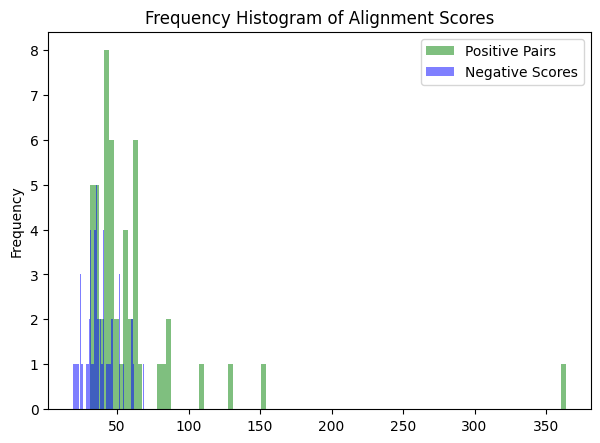

In [86]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.hist(pos_scores, alpha=0.5, bins=100, color='g', label='Positive Pairs')
plt.hist(neg_scores, alpha=0.5, bins=50, color='b', label='Negative Scores')
plt.gca().set(title='Frequency Histogram of Alignment Scores', ylabel='Frequency')
plt.legend()

> I would describe this distribution as almost normal, with the exception of one positive outlier. Visually, you can see the negative score pairs have a similar distribution but shifted to a lower mean.  

2) Generate a confusion matrix indicating the frequency of false positives, false negatives, true positives, and true negatives when using the average alignment score as a threshold. What is the threshold value, and how does the confusion matrix suggest this algorithm performed?

In [87]:
t = sum(pos_scores + neg_scores )/len(pos_scores + neg_scores )
print("Threshold=", t, "\n")

actual_list = np.repeat(np.array(["Pos", "Neg"]), [len(pos_scores), len(neg_scores)], axis=0)
pred_list = []
for i in pos_scores:
    if i >= t: pred_list.append("Pos")
    else: pred_list.append("Neg")
for i in neg_scores:
    if i < t: pred_list.append("Neg")
    else: pred_list.append("Pos")
df_confusion = pd.crosstab(pd.Series(actual_list, name='Actual'), 
                           pd.Series(pred_list, name='Predicted'))
print(df_confusion)

Threshold= 49.13 

Predicted  Neg  Pos
Actual             
Neg         42    8
Pos         28   22


> The threshold value is 49.13. The confusion matrix suggest the algorithm (or threshold) is not tuned yet and performing just okay. The accuracy is 0.64 (42+22)/(42+22+8+28) which for alignment classifiers would be very low. In particular, there are quite a few positive pairs that are predicted to be negative. 

3) Create a ROC plot which shows the fraction of true positives on the Y axis and the fraction of false positives on the X axis. Please take care to make your ROC plots square, with both X and Y axes limited to the range [0:1].

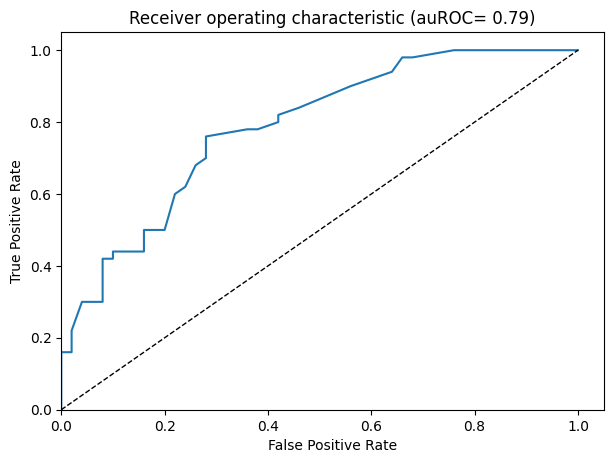

In [90]:
y_true = np.repeat(np.array([1, 0]), [len(pos_scores), len(neg_scores)], axis=0)
all_scores = pos_scores + neg_scores
y_pred = [x/max(all_scores) for x in all_scores]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

auroc = roc_auc_score(y_true, y_pred)
x=np.linspace(0,1) 
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(x,x,'k-', linestyle="--", color="black", linewidth=1)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (auROC= '+ str(round(auroc,2))+ ")")
plt.show()

4) Determine the area under the ROC curve (AUROC). What does this value indicate about the performance of this algorithm? Can you confidently assess the performance of this algorithm with this value alone? Why or why not? Having assessed the local alignment algorithm using the BLOSUM50 matrix, we are interested in determining how adjusting the gap penalties influences its performance.

In [91]:
print (roc_auc_score(y_true, y_pred))

0.7858


> This value indicates that the algorithm is performing better than expected (0.5), but not exceptionally well. Based on this value alone, I can not confidently asses the performance. I have a general feeling it should be improved, but this metric alone provides no intuition into other issues like data imbalanced. 

5) Once again, using local alignment, try a range of gap opening (1-20) and gap extension (1-5) costs with the BLOSUM62 matrix. Using the AUROC of each approach, determine which gap penalty performs the “best”. What does this pair of values suggest about the evolution of these sequences and the likelihood of insertions / deletions?

In [92]:
def amanda_helper(pwalign):
    pos_scores = []; neg_scores = []
    with open("scoring_matrices/Pospairs.txt") as fp:
        for line in fp:
            myfile = line.strip().split()
            b =pwalign.align(algs.FastaRecord(myfile[0]), algs.FastaRecord(myfile[1]), print_flag=False)
            pos_scores.append(b.top_score)
    with open("scoring_matrices/Negpairs.txt") as fp:
        for line in fp:
            myfile = line.strip().split()
            b =pwalign.align(algs.FastaRecord(myfile[0]), algs.FastaRecord(myfile[1]), print_flag=False)
            neg_scores.append(b.top_score)
    
    y_true = np.repeat(np.array([1, 0]), [len(pos_scores), len(neg_scores)], axis=0)
    all_scores = pos_scores + neg_scores
    y_pred = [x/max(all_scores) for x in all_scores]
    return (y_true, y_pred)

def amanda_roc(actual_list, pred_list, subtitle=""):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(actual_list, pred_list)
        roc_auc[i] = auc(fpr[i], tpr[i])

    x=np.linspace(0,1) 
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.plot(x,x,'k-', linestyle="--", color="black", linewidth=1)
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic\n' +subtitle)
    plt.show()
    return

In [105]:
a = np.load('Q5_mat.npy')
final_mat = a.tolist()
df = pd.DataFrame(final_mat, columns=["algorithm", 'Substitution Matrix', 'Gap Open', 'Gap Extension', "auROC"]) 
pd.set_option('display.max_rows', df.shape[0]+1)
print(df)

   algorithm Substitution Matrix Gap Open Gap Extension               auROC
0      local            BLOSUM62       -1            -1               0.745
1      local            BLOSUM62       -1            -2               0.745
2      local            BLOSUM62       -1            -3               0.745
3      local            BLOSUM62       -1            -4               0.745
4      local            BLOSUM62       -2            -1              0.7602
5      local            BLOSUM62       -2            -2              0.7738
6      local            BLOSUM62       -2            -3              0.7738
7      local            BLOSUM62       -2            -4              0.7738
8      local            BLOSUM62       -3            -1               0.781
9      local            BLOSUM62       -3            -2  0.7919999999999999
10     local            BLOSUM62       -3            -3               0.799
11     local            BLOSUM62       -3            -4               0.799
12     local

> The auROC specifies that a gap opening penalty of -4 and gap extension penality of -4 results in the best performance. This suggests the sequences are further in evolutionary history from each other and we should expect gaps to occur frequently. It is not beneficial to severly punish gaps (eg. -10) as sequences are not perfectly homolgous and are bound to have some gaps. Towards the other extreme, performance is low when you don't penalize gaps at all (eg -1) because this will allow more spurious mismatches to be formed that also don't reflect biology. This pair of values intuitively suggests that indels are common, particularly indels > 1bp are common, and there is a reasonable balance between how severly you penalize gaps based on the sequences' evolutionary expectation. 

6) Using the BLOSUM50, BLOSUM62, PAM100 and PAM250 scoring matrices, evaluate the performance of the global alignment algorithm using the selected pair of best performing gap penalties. Evaluate your optional additional extension algorithm as well, using the parameters it requires.

> Hi, plotting the ROC curves for Q7 here because its time consuming to separate and store these values. Also I did no additional algorithm extensions. 

In [ ]:
for ugh in ["BLOSUM62", "BLOSUM50", "PAM100", "PAM250"]:
    o = -4
    e = -4
    print (ugh)
    #Global
    nw = algs.NeedlemanWunsch(gap_open=o, gap_extension = e, substitutionMatrix = ugh)
    y_true, y_pred = amanda_helper(nw)
    final_val = roc_auc_score(y_true, y_pred)
    final_mat.append(["global", ugh, o, e, final_val])
    amanda_roc(y_true, y_pred, subtitle= ugh + " global")
    
    #LOCAL
    sw = algs.SmithWaterman(gap_open=o, gap_extension = e, substitutionMatrix = ugh)
    y_true, y_pred = amanda_helper(nw)
    final_val = roc_auc_score(y_true, y_pred)
    final_mat.append(["local", ugh, o, e, final_val])
    amanda_roc(y_true, y_pred, subtitle= ugh + " local")
    


BLOSUM62


7) For each algorithm, generate a ROC plot demonstrating performance using each of the 4 matrices, given the fixed gap costs. Of all these algorithms, which performs the best as measured by AUROC?

In [51]:
df = pd.DataFrame(final_mat, columns=["algorithm", 'Substitution Matrix', 'Gap Open', 'Gap Extension', "auROC"])
print(df)

  algorithm Substitution Matrix  Gap Open  Gap Extension  auROC
0     local            BLOSUM62        -1             -1   0.64
1     local            BLOSUM62        -1             -4   0.64
2     local            BLOSUM62       -11             -1   0.65
3     local            BLOSUM62       -11             -4   0.63
4    global            BLOSUM62        -5             -3   0.65
5     local            BLOSUM62        -5             -3   0.65


> See ROC plots above. Given the 8 combinations, ___ perfomed the best as measured by auROC. 

8) Comment qualitatively on the best algorithm. What does the best performing algorithm indicate about the origin of these sequences?

> Based on the locally ideal gap penalty of -4, it suggests the sequences are further in evolutionary history from each other and we should expect gaps to occur frequently. If the ideal penalty was -10 it would suggest the sequences are highly homologous. 